In [440]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns
import datetime
from sqlalchemy import create_engine
from dateutil.parser import parse
import dateutil.parser
%matplotlib inline

In [3]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"  
    dfs = []
    for week_num in week_nums: 
        file_url = url.format(week_num) 
        dfs.append(pd.read_csv(file_url)) 
    return pd.concat(dfs) 
        

In [4]:
'''week_nums = [190105,
190202,
190302,
190406,
190504,
190601,
190706,
190803,
190907,
191005,
191102,
191207,
200104,
200201,
200307,
200404,
200502,
200606,
200704,
200801,
200905,
201003,
201107,
201205]
mta_project_df = get_data(week_nums)'''

'week_nums = [190105,\n190202,\n190302,\n190406,\n190504,\n190601,\n190706,\n190803,\n190907,\n191005,\n191102,\n191207,\n200104,\n200201,\n200307,\n200404,\n200502,\n200606,\n200704,\n200801,\n200905,\n201003,\n201107,\n201205]\nmta_project_df = get_data(week_nums)'

In [6]:
'''week_nums = [190112,
190202,
190302,
190406,
190504,
190601,
190706,
190803,
190907,
191005,
191102,
191207]

week_nums2 = [200111,
200201,
200307,
200404,
200502,
200606,
200704,
200801,
200905,
201003,
201107,
201205]'''

#week_nums3 = ['191005', '191012', '191019','191026']
#mta_project_df = get_data(week_nums3)

In [122]:
#week_nums_oct2020 = ['201010','201017','201024','201031']
#mta_project_df = get_data(week_nums_oct2020)

In [123]:
#mta_project_df.to_csv('october_2020.csv',header=False,index=False)
#mta_project_df.to_csv('october_2019.csv', header=False, index=False)
#mta_project_df.to_csv('mta_project_data_2019.csv', header=False, index=False)
#mta_project_df2.to_csv('mta_project_data_2020.csv', header=False, index=False)

In [441]:
engine = create_engine("sqlite:///mta_project.db")

In [442]:
year2019 = pd.read_sql('SELECT * FROM mta_data;', engine)

In [443]:
year2020 = pd.read_sql('SELECT * FROM mta_data2;', engine)

In [32]:
test=pd.read_sql('SELECT DATE,TIME from mta_oct;',engine)

In [444]:
def cleandf(df):
    #df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME,format="%m/%d/%Y %H:%M:%S")
    df['DATE_TIME']=pd.to_datetime(df['DATE'] + " " + df['TIME'])
    df['DAY_OF_WK'] = df['DATE_TIME'].dt.dayofweek
    df['WK_OF_YR'] = df['DATE_TIME'].dt.week
    df.sort_values(["CA", "UNIT", "SCP", "STATION", "DATE_TIME"],inplace=True, ascending=False)
    df.drop_duplicates(subset=["CA", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)
    return df['DATE_TIME'], df['DAY_OF_WK']

In [445]:
year2020['DATE_TIME'],year2020['DAY_OF_WK']=cleandf(year2020)

<ipython-input-444-7fd5a7da0b76>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['WK_OF_YR'] = df['DATE_TIME'].dt.week


In [446]:
year2019['DATE_TIME'],year2019['DAY_OF_WK']=cleandf(year2019)

<ipython-input-444-7fd5a7da0b76>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['WK_OF_YR'] = df['DATE_TIME'].dt.week


In [447]:
turnstiles_daily = (year2019
                        .groupby(["CA", "UNIT", "SCP", "STATION", "DATE","DAY_OF_WK","WK_OF_YR", "DATE_TIME", "TIME"],as_index=False).ENTRIES.first())

turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["CA", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)



<ipython-input-447-b2ef29a90616>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily


In [448]:
turnstiles_daily.head()

,CA,UNIT,SCP,STATION,DATE,DAY_OF_WK,WK_OF_YR,DATE_TIME,TIME,ENTRIES,PREV_DATE,PREV_ENTRIES
1,A002,R051,02-00-00,59 ST,01/05/2019,5,1,2019-01-05 07:00:00,07:00:00,6897023,01/05/2019,6897012.0
2,A002,R051,02-00-00,59 ST,01/05/2019,5,1,2019-01-05 11:00:00,11:00:00,6897083,01/05/2019,6897023.0
3,A002,R051,02-00-00,59 ST,01/05/2019,5,1,2019-01-05 15:00:00,15:00:00,6897262,01/05/2019,6897083.0
4,A002,R051,02-00-00,59 ST,01/05/2019,5,1,2019-01-05 19:00:00,19:00:00,6897572,01/05/2019,6897262.0
5,A002,R051,02-00-00,59 ST,01/05/2019,5,1,2019-01-05 23:00:00,23:00:00,6897740,01/05/2019,6897572.0


In [449]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:

        counter = -counter
    if counter > max_counter:

        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:

        return 0
    return counter
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

In [450]:
'''def get_exit_counts(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:

        counter = -counter
    if counter > max_counter:

        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter > max_counter:

        return 0
    return counter'''

'def get_exit_counts(row, max_counter):\n    counter = row["EXITS"] - row["PREV_EXITS"]\n    if counter < 0:\n\n        counter = -counter\n    if counter > max_counter:\n\n        counter = min(row["EXITS"], row["PREV_EXITS"])\n    if counter > max_counter:\n\n        return 0\n    return counter'

In [451]:
turnstiles_daily.head()

,CA,UNIT,SCP,STATION,DATE,DAY_OF_WK,WK_OF_YR,DATE_TIME,TIME,ENTRIES,PREV_DATE,PREV_ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,01/05/2019,5,1,2019-01-05 07:00:00,07:00:00,6897023,01/05/2019,6897012.0,11.0
2,A002,R051,02-00-00,59 ST,01/05/2019,5,1,2019-01-05 11:00:00,11:00:00,6897083,01/05/2019,6897023.0,60.0
3,A002,R051,02-00-00,59 ST,01/05/2019,5,1,2019-01-05 15:00:00,15:00:00,6897262,01/05/2019,6897083.0,179.0
4,A002,R051,02-00-00,59 ST,01/05/2019,5,1,2019-01-05 19:00:00,19:00:00,6897572,01/05/2019,6897262.0,310.0
5,A002,R051,02-00-00,59 ST,01/05/2019,5,1,2019-01-05 23:00:00,23:00:00,6897740,01/05/2019,6897572.0,168.0


In [452]:
stations_daily=(turnstiles_daily.groupby(['STATION', 'DATE'])[['DAILY_ENTRIES']].sum().reset_index())
stations_daily

,STATION,DATE,DAILY_ENTRIES
0,1 AV,01/05/2019,12448.0
1,1 AV,01/06/2019,12021.0
2,1 AV,01/07/2019,19538.0
3,1 AV,01/08/2019,20414.0
4,1 AV,01/09/2019,21066.0
...,...,...,...
31679,ZEREGA AV,12/02/2019,2752.0
31680,ZEREGA AV,12/03/2019,2967.0
31681,ZEREGA AV,12/04/2019,3055.0
31682,ZEREGA AV,12/05/2019,3029.0


In [453]:
stations_daily_dow=(turnstiles_daily.groupby(['STATION', 'DATE','DAY_OF_WK','WK_OF_YR','DATE_TIME','TIME'])[['DAILY_ENTRIES']].sum().reset_index())
stations_daily_dow

,STATION,DATE,DAY_OF_WK,WK_OF_YR,DATE_TIME,TIME,DAILY_ENTRIES
0,1 AV,01/05/2019,5,1,2019-01-05 07:00:00,07:00:00,295.0
1,1 AV,01/05/2019,5,1,2019-01-05 11:00:00,11:00:00,1356.0
2,1 AV,01/05/2019,5,1,2019-01-05 15:00:00,15:00:00,3125.0
3,1 AV,01/05/2019,5,1,2019-01-05 19:00:00,19:00:00,4120.0
4,1 AV,01/05/2019,5,1,2019-01-05 23:00:00,23:00:00,3552.0
...,...,...,...,...,...,...,...
361772,ZEREGA AV,12/06/2019,4,49,2019-12-06 04:00:00,04:00:00,26.0
361773,ZEREGA AV,12/06/2019,4,49,2019-12-06 08:00:00,08:00:00,926.0
361774,ZEREGA AV,12/06/2019,4,49,2019-12-06 12:00:00,12:00:00,793.0
361775,ZEREGA AV,12/06/2019,4,49,2019-12-06 16:00:00,16:00:00,535.0


In [454]:
stations_daily_dow['DAY_OF_WK'].value_counts()

3    52157
2    52151
1    51788
0    51786
4    51580
6    51559
5    50756
Name: DAY_OF_WK, dtype: int64

In [455]:
stn = stations_daily.groupby(['STATION']).sum().sort_values('DAILY_ENTRIES',ascending=False).reset_index()
stn.head(10)


,STATION,DAILY_ENTRIES
0,34 ST-PENN STA,53818981.0
1,GRD CNTRL-42 ST,44897228.0
2,23 ST,37060676.0
3,34 ST-HERALD SQ,36966406.0
4,TIMES SQ-42 ST,30852976.0
5,42 ST-PORT AUTH,30795213.0
6,14 ST-UNION SQ,30534427.0
7,FULTON ST,28441368.0
8,86 ST,25817570.0
9,CANAL ST,25763328.0


In [457]:
dow_counts = stations_daily_dow.groupby(['DAY_OF_WK'])['DAILY_ENTRIES'].mean().reset_index()

In [458]:
dow_counts

,DAY_OF_WK,DAILY_ENTRIES
0,0,1281.463021
1,1,1534.027207
2,2,1512.662212
3,3,1475.255613
4,4,1536.640054
5,5,27904.786232
6,6,712.108769


In [459]:
top_wk = stations_daily_dow.loc[(stations_daily_dow['STATION']=='34 ST-PENN STA') |(stations_daily_dow['STATION']=='GRD CNTRL-42 ST')|(stations_daily_dow['STATION']=='23 ST')|(stations_daily_dow['STATION']=='34 ST-HERALD SQ')|(stations_daily_dow['STATION']=='TIMES SQ-42 ST')|(stations_daily_dow['STATION']=='42 ST-PORT AUTH')|(stations_daily_dow['STATION']=='14 ST-UNION SQ')|(stations_daily_dow['STATION']=='FULTON ST')|(stations_daily_dow['STATION']=='86 ST')|(stations_daily_dow['STATION']=='CANAL ST')]
top_wk['DATE']=pd.to_datetime(top_wk['DATE'])
top_wk = top_wk.drop(index = 41267)
top_wk = top_wk.drop(index = 41283)
top_wk = top_wk[top_wk['DAY_OF_WK'].isin([0,1,2,3,4])]

<ipython-input-459-9e99de4328b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_wk['DATE']=pd.to_datetime(top_wk['DATE'])


In [460]:
top_wk

,STATION,DATE,DAY_OF_WK,WK_OF_YR,DATE_TIME,TIME,DAILY_ENTRIES
9347,14 ST-UNION SQ,2019-01-07,0,2,2019-01-07 00:00:00,00:00:00,9445.0
9348,14 ST-UNION SQ,2019-01-07,0,2,2019-01-07 04:00:00,04:00:00,1203.0
9349,14 ST-UNION SQ,2019-01-07,0,2,2019-01-07 08:00:00,08:00:00,3492.0
9350,14 ST-UNION SQ,2019-01-07,0,2,2019-01-07 12:00:00,12:00:00,13773.0
9351,14 ST-UNION SQ,2019-01-07,0,2,2019-01-07 16:00:00,16:00:00,20345.0
...,...,...,...,...,...,...,...
343730,TIMES SQ-42 ST,2019-12-06,4,49,2019-12-06 18:45:19,18:45:19,53.0
343731,TIMES SQ-42 ST,2019-12-06,4,49,2019-12-06 18:46:40,18:46:40,37.0
343732,TIMES SQ-42 ST,2019-12-06,4,49,2019-12-06 18:48:00,18:48:00,60.0
343733,TIMES SQ-42 ST,2019-12-06,4,49,2019-12-06 19:00:00,19:00:00,34831.0


In [465]:
totals = top_wk.groupby(by='STATION',as_index=False).sum()[['STATION','DAILY_ENTRIES']].sort_values('DAILY_ENTRIES',ascending=False)
totals

,STATION,DAILY_ENTRIES
3,34 ST-PENN STA,10101962.0
8,GRD CNTRL-42 ST,9696491.0
2,34 ST-HERALD SQ,7786421.0
1,23 ST,7309510.0
7,FULTON ST,6377787.0
4,42 ST-PORT AUTH,6119484.0
0,14 ST-UNION SQ,5971663.0
9,TIMES SQ-42 ST,5897598.0
5,86 ST,5036003.0
6,CANAL ST,4547851.0


In [466]:
top_wk['TIMEP']=top_wk['TIME'].apply(parse)

In [495]:

stations10 = top_wk[top_wk['STATION'].isin(['34 ST-PENN STA',
                   'GRD CNTRL-42 ST',
                   '23 ST',
                   '34 ST-HERALD SQ',
                   'TIMES SQ-42 ST',
                   '42 ST-PORT AUTH',
                   '14 ST-UNION SQ',
                   'FULTON ST',
                   '86 ST',
                   'CANAL ST'])]

stations10 = stations10.groupby(by=['STATION', 'TIMEP'], as_index=False).sum()[['STATION', 'TIMEP','DAILY_ENTRIES']]
stations10.set_index('TIMEP', drop=True, inplace=True)
stations10 = stations10.groupby(by=['STATION']).resample('4H').mean()
stations10 = stations10.reset_index()

In [472]:
stations10.head()

,STATION,TIMEP,DAILY_ENTRIES
0,14 ST-UNION SQ,2021-04-30 00:00:00,391740.000000
1,14 ST-UNION SQ,2021-04-30 04:00:00,18504.500000
2,14 ST-UNION SQ,2021-04-30 08:00:00,32620.333333
3,14 ST-UNION SQ,2021-04-30 12:00:00,241527.500000
4,14 ST-UNION SQ,2021-04-30 16:00:00,757194.500000


In [474]:
stn_wk = top_wk[top_wk['STATION'].isin(['34 ST-PENN STA',
                   'GRD CNTRL-42 ST',
                   '23 ST',
                   '34 ST-HERALD SQ',
                   'TIMES SQ-42 ST',
                   '42 ST-PORT AUTH',
                   '14 ST-UNION SQ',
                   'FULTON ST',
                   '86 ST',
                   'CANAL ST'])]
stn_wk = stn_wk.groupby(by=['STATION', 'DAY_OF_WK'], as_index=False).sum()[['STATION', 'DAY_OF_WK','DAILY_ENTRIES']]
stn_wk.head()



,STATION,DAY_OF_WK,DAILY_ENTRIES
0,14 ST-UNION SQ,0,1011593.0
1,14 ST-UNION SQ,1,1312641.0
2,14 ST-UNION SQ,2,1245161.0
3,14 ST-UNION SQ,3,1179677.0
4,14 ST-UNION SQ,4,1222591.0


/Users/ju/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


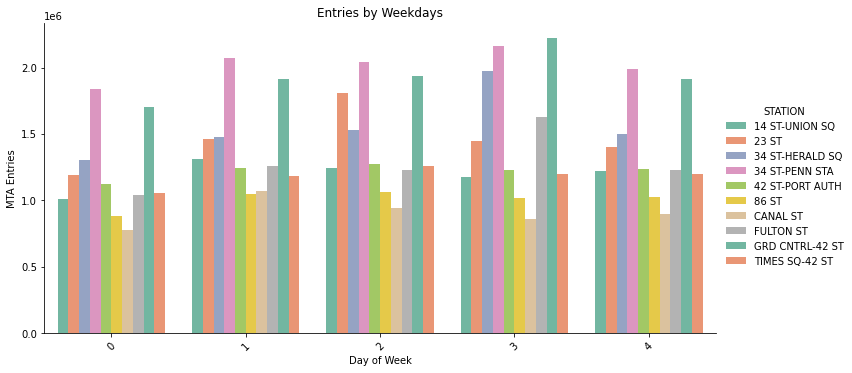

In [475]:
stn_wk.loc[stn_wk['DAY_OF_WK'] == '0', 'day'] = 'Monday'
stn_wk.loc[stn_wk['DAY_OF_WK'] == '1', 'day'] = 'Tuesday'
stn_wk.loc[stn_wk['DAY_OF_WK'] == '2', 'day'] = 'Wednesday'
stn_wk.loc[stn_wk['DAY_OF_WK'] == '3', 'day'] = 'Thursday'
stn_wk.loc[stn_wk['DAY_OF_WK'] == '4', 'day'] = 'Friday'

weekday_bar = sns.catplot('DAY_OF_WK', 'DAILY_ENTRIES', hue ='STATION', kind = 'bar', data = stn_wk, aspect = 2, palette=sns.color_palette("Set2"))

'''labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = 'Monday'
labels[1] = 'Tuesday'
labels[2] = 'Wednesday'
labels[3] = 'Thursday'
labels[4] = 'Friday'
ax.set_yticklabels(labels)
ax.set_xlabel('Day of Week')
ax.set_ylabel('MTA Entries')'''


plt.xticks(rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('MTA Entries')
plt.title('Entries by Weekdays');





In [476]:
test = top_wk[top_wk['STATION'].isin(['34 ST-PENN STA'])]
test.sort_values('DAILY_ENTRIES',ascending=False)

,STATION,DATE,DAY_OF_WK,WK_OF_YR,DATE_TIME,TIME,DAILY_ENTRIES,TIMEP
41302,34 ST-PENN STA,2019-02-28,3,9,2019-02-28 15:00:00,15:00:00,142313.0,2021-04-30 15:00:00
41156,34 ST-PENN STA,2019-01-29,1,5,2019-01-29 11:00:00,11:00:00,50368.0,2021-04-30 11:00:00
41238,34 ST-PENN STA,2019-02-25,0,9,2019-02-25 11:00:00,11:00:00,49138.0,2021-04-30 11:00:00
41068,34 ST-PENN STA,2019-01-08,1,2,2019-01-08 11:00:00,11:00:00,49064.0,2021-04-30 11:00:00
41144,34 ST-PENN STA,2019-01-28,0,5,2019-01-28 11:00:00,11:00:00,48905.0,2021-04-30 11:00:00
...,...,...,...,...,...,...,...,...
41299,34 ST-PENN STA,2019-02-28,3,9,2019-02-28 12:48:55,12:48:55,3.0,2021-04-30 12:48:55
41696,34 ST-PENN STA,2019-07-05,4,27,2019-07-05 08:36:14,08:36:14,2.0,2021-04-30 08:36:14
41202,34 ST-PENN STA,2019-02-01,4,5,2019-02-01 11:59:00,11:59:00,2.0,2021-04-30 11:59:00
41295,34 ST-PENN STA,2019-02-28,3,9,2019-02-28 12:46:20,12:46:20,0.0,2021-04-30 12:46:20


In [477]:
stations10.loc[stations10['TIMEP'] == '08:00:00']

,STATION,TIMEP,DAILY_ENTRIES
2,14 ST-UNION SQ,2021-04-30 08:00:00,32620.333333
8,23 ST,2021-04-30 08:00:00,23556.000000
14,34 ST-HERALD SQ,2021-04-30 08:00:00,58216.636364
20,34 ST-PENN STA,2021-04-30 08:00:00,28519.562500
26,42 ST-PORT AUTH,2021-04-30 08:00:00,101129.250000
32,86 ST,2021-04-30 08:00:00,49184.277778
38,CANAL ST,2021-04-30 08:00:00,15713.083333
44,FULTON ST,2021-04-30 08:00:00,7644.142857
50,GRD CNTRL-42 ST,2021-04-30 08:00:00,13220.460674
56,TIMES SQ-42 ST,2021-04-30 08:00:00,9122.943396


In [485]:
stations10.loc[stations10['TIMEP'] == '00:00:00', 'dt'] = '8:00 PM - Midnight'


In [486]:
stations10.loc[stations10['TIMEP'] == '04:00:00', 'dt'] = 'Midnight - 4:00 AM'


In [487]:
stations10.loc[stations10['TIMEP'] == '08:00:00', 'dt'] = '4:00 AM - 8:00 AM'

In [488]:
stations10.loc[stations10['TIMEP'] == '12:00:00', 'dt'] = '8:00 AM - Noon'


In [489]:
stations10.loc[stations10['TIMEP'] == '16:00:00', 'dt'] = 'Noon - 4:00 PM'
stations10.loc[stations10['TIMEP'] == '20:00:00', 'dt'] = '4:00 PM - 8:00 PM'

In [490]:
stations10['AVG_ENTRIES'] = stations10['DAILY_ENTRIES'].mean()

/Users/ju/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Entries by Time of Day (2019)')

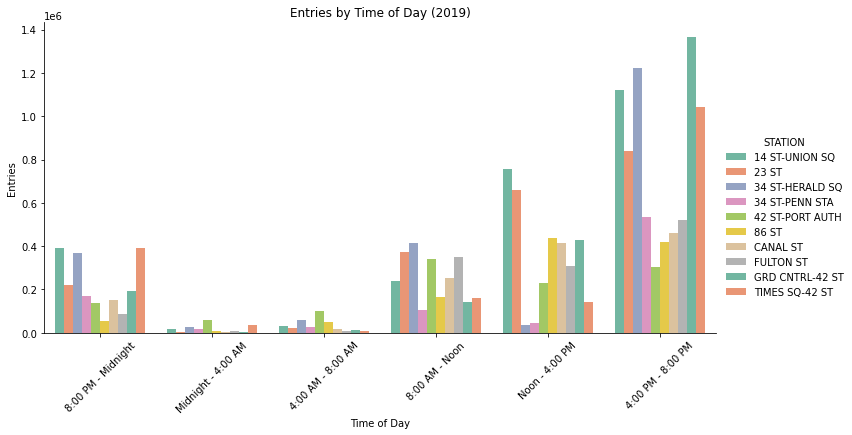

In [491]:
chart = sns.catplot('dt', 'DAILY_ENTRIES', hue ='STATION', kind = 'bar', data = stations10, aspect = 2, palette=sns.color_palette("Set2"))
plt.xticks(rotation=45)
plt.ylabel('Entries')


plt.xlabel('Time of Day')

plt.title("Entries by Time of Day (2019)")





<BarContainer object of 50 artists>

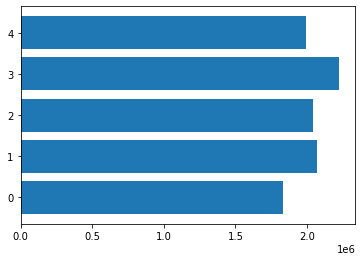

In [492]:
x = stn_wk['DAY_OF_WK']
y = stn_wk['DAILY_ENTRIES']

plt.barh(x,y)

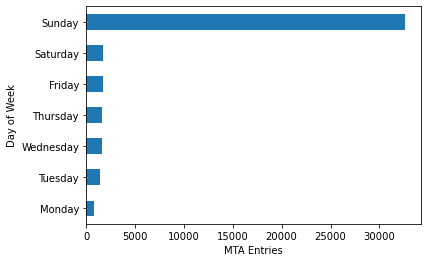

In [493]:
plotframe=stations_daily_dow[stations_daily_dow['DAILY_ENTRIES']!=0]
ax = plotframe.groupby('DAY_OF_WK').DAILY_ENTRIES.mean().sort_values().plot(kind='barh')
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = 'Monday'
labels[1] = 'Tuesday'
labels[2] = 'Wednesday'
labels[3] = 'Thursday'
labels[4] = 'Friday'
labels[5] = 'Saturday'
labels[6] = 'Sunday'
ax.set_yticklabels(labels)
ax.set_ylabel('Day of Week')
ax.set_xlabel('MTA Entries')

plt.show()



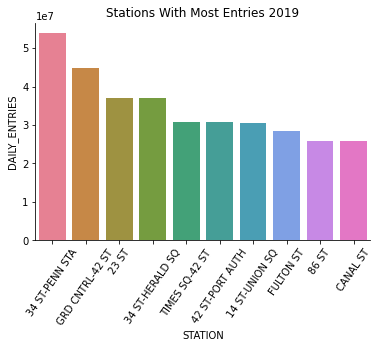

In [494]:
chart = sns.barplot(x ='STATION',y='DAILY_ENTRIES',data=stn[:10],palette = sns.color_palette("husl", 10));
chart.set_xticklabels(chart.get_xticklabels(), rotation=55)
chart.set_title('Stations With Most Entries 2019')
sns.despine()

plt.savefig('2019_daily_entries.png')